In [1]:
import matplotlib.patches as mpatches
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as ln
import colour as cl

Text(0.5, 1.0, 'print paper dye sensitity')

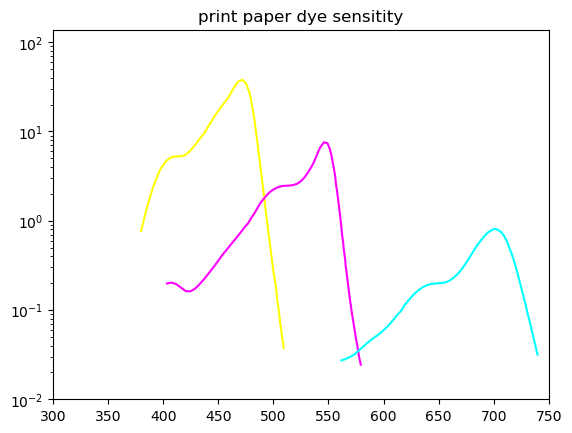

In [2]:
# ektarcolor edge paper spec
y = np.genfromtxt('./ektarcolor_edge/yellow.csv', delimiter=',').T
m = np.genfromtxt('./ektarcolor_edge/magenta.csv', delimiter=',').T
c = np.genfromtxt('./ektarcolor_edge/cyan.csv', delimiter=',').T

fig, ax = plt.subplots()
ax.plot(y[0],np.power(10,y[1]),c='yellow')
ax.plot(m[0],np.power(10,m[1]),c='magenta')
ax.plot(c[0],np.power(10,c[1]),c='cyan')
ax.set_xlim(300,750)
ax.set_ylim(0.01,np.max(np.power(10,y[1]))+100)
ax.set_yscale('log')
ax.set_title('print paper dye sensitity')

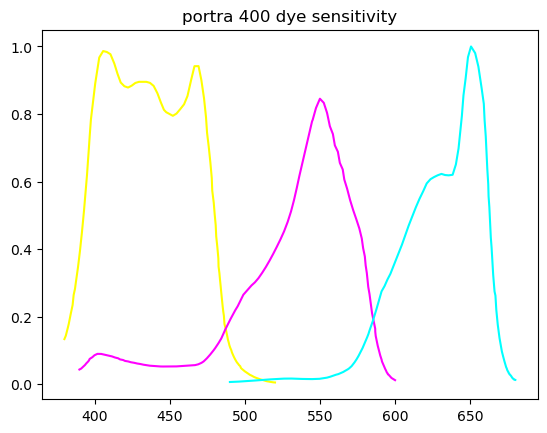

In [3]:
# portra 400 dye sensitivity in -log(1/exposure) 
y_sens = np.genfromtxt('./portra400/y_sens.csv', delimiter=',')
m_sens = np.genfromtxt('./portra400/m_sens.csv', delimiter=',')
c_sens = np.genfromtxt('./portra400/c_sens.csv', delimiter=',')

n_f = 10**np.max(np.hstack((y_sens[:,1],m_sens[:,1],c_sens[:,1]))) # nomorliztion factor
y_sens[:,1] = 10**(y_sens[:,1])/n_f
m_sens[:,1] = 10**(m_sens[:,1])/n_f
c_sens[:,1] = 10**(c_sens[:,1])/n_f
fig, ax = plt.subplots()

ax.plot(y_sens[:,0],y_sens[:,1],c='yellow')
ax.plot(m_sens[:,0],m_sens[:,1],c='magenta')
ax.plot(c_sens[:,0],c_sens[:,1],c='cyan')
ax.set_title('portra 400 dye sensitivity')
plt.show()
# integral over spectrum get the trsimission of dye, two times of light, two times of absorbtion, one half of dye's transimission: -log(transimission) = k* log(exposure)

Text(0.5, 1.0, 'film dye density')

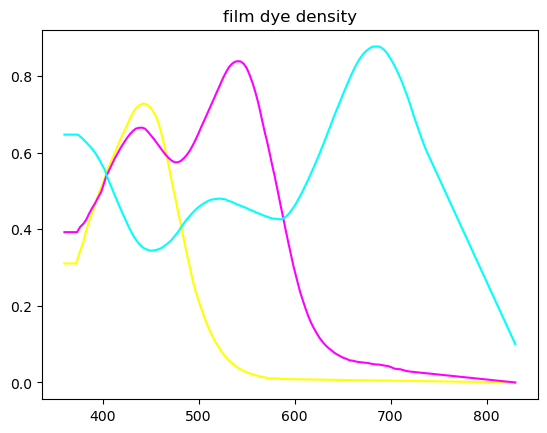

In [4]:
# color film dye transimission, in density (-log(transimission))
y_d = np.genfromtxt('./portra400/y_d.csv', delimiter=',')
m_d = np.genfromtxt('./portra400/m_d.csv', delimiter=',')
c_d = np.genfromtxt('./portra400/c_d.csv', delimiter=',')

fig, ax = plt.subplots()
ax.plot(y_d[:,0],y_d[:,1],c='yellow')
ax.plot(m_d[:,0],m_d[:,1],c='magenta')
ax.plot(c_d[:,0],c_d[:,1],c='cyan')
# ax.set_xlim(300,750)
# ax.set_ylim(0.01,np.max(np.power(10,y[1]))+100)
ax.set_title('film dye density')

In [5]:
# some functions
# interpolat above 6 curves
from scipy.interpolate import interp1d
def inter(list,minw=360,maxw=830):
    """
    data list
    """
    return_list = []
    for data in list:
        data_min = np.around(data[0,0])
        data_max = np.around(data[-1,0])
        f = interp1d(data[:,0],data[:,1])
        wavelength = np.arange(data_min+1,data_max) # 1nm step length
        new_data= f(wavelength)
        filling_wavelength_short = np.arange(minw,wavelength[0])
        filling_wavelength_long = np.arange(wavelength[-1]+1,maxw+1)
        filling_wavelength_short = np.vstack((filling_wavelength_short, np.zeros_like(filling_wavelength_short))).T
        filling_wavelength_long = np.vstack((filling_wavelength_long, np.zeros_like(filling_wavelength_long))).T
        new_data = np.hstack((np.zeros((int(wavelength[0]-minw),)), new_data))
        new_data = np.hstack((new_data, np.zeros((int(maxw-wavelength[-1]),))))
        return_list.append(new_data)
    
    return np.array(return_list).T

def inter_for_dye_dens(list,minw=360,maxw=830):
    """
    data list
    """
    return_list = []
    for data in list:
        data_min = np.around(data[0,0])
        data_max = np.around(data[-1,0])
        f = interp1d(data[:,0],data[:,1])
        wavelength = np.arange(int(data_min),int(data_max+1)) # 1nm step length
        new_data= f(wavelength)
        return_list.append(new_data)
    
    return np.array(return_list).T

In [6]:
minw=360
maxw=830

film_sens = inter([y_sens,m_sens,c_sens])

# xrite 24 color
xrite_spectrum = np.genfromtxt('./xrite/xrite_cherker_spectrum.csv',delimiter=' ') # 24colors 380-730, row is spectrum, coloumn is wavelength
xtire_wavelength = np.linspace(380,730,36)
xrite_inter = interp1d(xtire_wavelength,xrite_spectrum) # interpolate
xrite_wavelength_1nm = np.arange(380,731)
xrite_spectrum = xrite_inter(xrite_wavelength_1nm)
xrite_spectrum = np.hstack( (np.zeros((24,380-minw)), xrite_spectrum) )
xrite_spectrum = np.hstack( (xrite_spectrum, np.zeros((24,maxw-730)) ) ) # filling to 360-830 with 0

For one dye, minimum density is 0, which corresponds to transmission is 1. 
$$
-\log T = D = k \log(\mathrm{Exposure})\\
D = k\log(\mathrm{Response})
$$
Now we have the netural density. Assume the midscale neutral is theaverage of x-rite 24 color checker color 21 and 22. Intergral with the dye sensitivity, then let three $\log(\mathrm{Response})$ equal to 1, we get the normalization factor of three response value, then apply them to all x-rite 24 color's response.

Then the $k$ for each wavelength is the the  midscale neutral dye density curve above. 

In [7]:
# calculate the normalization factor
netural = (xrite_spectrum[20]+xrite_spectrum[21])/2

netural_negtive_response = np.dot(netural,film_sens)
normalization_factor = 10/netural_negtive_response

# 24 colors' response
xrite_film_response = np.dot(xrite_spectrum,film_sens) 


# film base density and trans 
base_d = np.genfromtxt('./portra400/film_base.csv', delimiter=',')
base_d = interp1d(base_d[:,0],base_d[:,1]) # interpolate
wavelength_1nm = np.arange(360,831)
base_d = base_d(wavelength_1nm)
base_trans = -np.log10(base_d)

In [8]:
# film spectral trans for 24 colors (only the response part)
dye_dens = inter_for_dye_dens([y_d,m_d,c_d]) # interpolate first
xrite_on_film_dens = []
for row in xrite_film_response:
    dens_spectrum_rgb = dye_dens*np.log10(row) # k*R
    dens_spectrum = np.sum(dens_spectrum_rgb,axis=-1) # three dyes in total 
    xrite_on_film_dens.append(dens_spectrum)
xrite_on_film_dens = np.array(xrite_on_film_dens)

# plus film base
xrite_on_film_dens = xrite_on_film_dens+base_d

# convert to transimission
xrite_on_film_trans = 10**(-xrite_on_film_dens)

In [9]:
# 5000K blackbody spectrum
def _plank(wavelength,T):
    h = 6.626e-34
    c = 3e8
    k = 1.38e-23
    wavelength = wavelength*1e-9
    I = (2*k*c**2/wavelength**5)*(1/(np.exp(h*c/wavelength/k/T)-1))
    return I
plank = np.vectorize(_plank)

blackbody = plank(np.arange(360,831),6500)/np.max(plank(np.arange(360,831),5000))

In [10]:
# film spectrum with 5000K light
xrite_on_film_spectrum = xrite_on_film_trans*blackbody


In [11]:
def inner(spectrum, cmf):
    """
    spectrum shuold be (m,n) array, row is spectrum

    cmf should be (n,3) array

    return (m,3)
    """
    R = np.inner(spectrum, cmf[:,0])
    G = np.inner(spectrum, cmf[:,1])
    B = np.inner(spectrum, cmf[:,2])
    rgb = np.vstack((R,G,B)).T
    rgb = rgb/np.max(rgb)
    return rgb

In [12]:
# APD CMF
APD = np.genfromtxt('./cmfs/APD_CMF.csv',delimiter=',') # from 360-730, step 2nm
APD = interp1d(APD[:,0],APD[:,1:].T) # interpolate
APD = APD(np.arange(360,731)).T # 360-730, 1nm
cmf_APD = np.vstack((APD,np.zeros((100,3)))) # enlarge to 360-830
cmf_APD.shape

(471, 3)

In [13]:
# P3 D65 CMF from CIE1931 2 degree 
cmf_XYZ = np.genfromtxt('./cmfs/ciexyz31_1.csv', delimiter=',') #360-830, 1nm
cmf_XYZ = cmf_XYZ[:,1:] #drop wavelength column
T_cieXYZ_to_p3d65 = np.array([[2.493497, -0.931384, -0.402711],
                              [-0.829489, 1.762664,  0.023625],
                              [0.035846, -0.076172,  0.956885]])
cmf_p3d65 = np.dot(cmf_XYZ, T_cieXYZ_to_p3d65.T)
cmf_p3d65.shape

(471, 3)

In [14]:
xrite_on_film_spectrum.shape

(24, 471)

In [15]:
xr_p3 = inner(xrite_on_film_spectrum,cmf_p3d65)
xr_apd = inner(xrite_on_film_spectrum,cmf_APD)
ccm_p3_to_apd = ln.lstsq(xr_p3,xr_apd)[0].T
ccm_p3_to_apd

/var/folders/cv/3w4fv3096tq_v6gkm2b1x3vm0000gn/T/ipykernel_22801/878885526.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ccm_p3_to_apd = ln.lstsq(xr_p3,xr_apd)[0].T


array([[ 0.91289126,  0.23086323, -0.21623707],
       [-0.02795929,  0.63340891,  0.03470275],
       [ 0.00325228,  0.00232736,  0.92028927]])

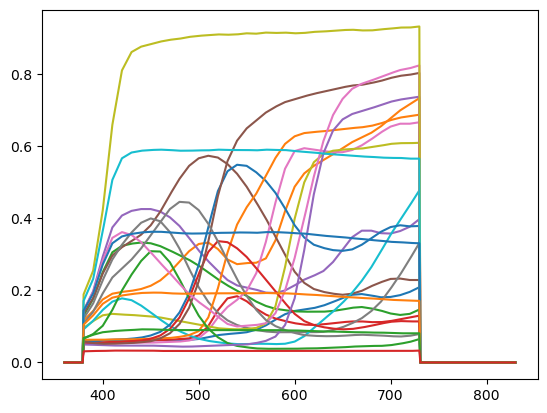

In [16]:
cmf = xrite_spectrum.T 
fig, ax = plt.subplots()
for row in cmf.T:
    ax.plot(np.arange(360,831),row)


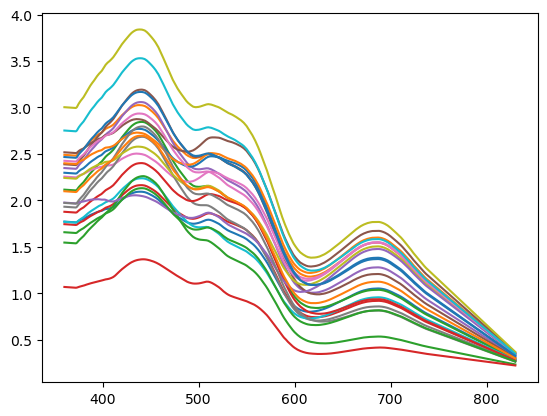

In [17]:
cmf = xrite_on_film_dens.T
fig, ax = plt.subplots()
for row in cmf.T:
    ax.plot(np.arange(360,831),row)
